(e_new_vectors)=
 
----------------
**Learning Objectives**
* Create new geospatial objects (points, lines, polygons)
* Assign the correct projection or CRS
* Create points from a table or csv of lat and lon 

**Review**
* [CRS what is it?](d_crs_what_is_it)
* [Understand CRS codes](d_understand_crs_codes)
* [Vector data structures](c_vectors)
* [Find Lat Lon of your own points, lines, polygons](https://geojson.io/)

----------------


# Creating Spatial Data
We often find ourselves in a situation where we need to generate new spatial data from scratch, or need to better understand how our data is constructed. This lesson will walk you through some of the most common forms of data generation. 

## Creating GeoDataFrame geometries
Since geopandas takes advantage of Shapely geometric objects it is possible to create a Shapefile from a scratch by passing Shapely’s geometric objects into the GeoDataFrame. This is useful as it makes it easy to convert e.g. a text file that contains coordinates into a Shapefile.

Let’s create an empty `GeoDataFrame` and create a new column called geometry that will contain our Shapely objects:

In [1]:
# Import necessary modules first
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import fiona
import matplotlib.pyplot as plt
plt.style.use('bmh') # better for plotting geometries vs general plots.

# Create an empty geopandas GeoDataFrame
newdata = gpd.GeoDataFrame()
# Create a new column called 'geometry' to the GeoDataFrame
newdata['geometry'] = None

print(newdata)

Empty GeoDataFrame
Columns: [geometry]
Index: []


Now we have a geometry column in our GeoDataFrame but we don’t have any data yet.

### Creating Points (addmitedly the long way)

Let’s create a Shapely Point representing the GWU Department of Geography that we can insert to our GeoDataFrame:

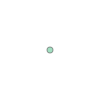

In [2]:
# Coordinates of the Helsinki Senate square in Decimal Degrees
coordinates = (-77.04639494419096,  38.89934963421794)

# Create a Shapely polygon from the coordinate-tuple list
point = Point(coordinates)

# Let's see what we have
point

Okay, so now we have appropriate Polygon -object.

Let’s insert the polygon into our ‘geometry’ column in our GeoDataFrame:

In [3]:
# Insert the polygon into 'geometry' -column at index 0
newdata.loc[0, 'geometry'] = point

# Let's see what we have now
newdata

,geometry
0,POINT (-77.04639 38.89935)


Now we have a GeoDataFrame with Point that we can export to a Shapefile.

Let’s add another column to our GeoDataFrame called Location with text GWU Geography.

In [4]:
# Add a new column and insert data
newdata.loc[0, 'Location'] = 'GWU Geography'

# Let's check the data
newdata

,geometry,Location
0,POINT (-77.04639 38.89935),GWU Geography


Okay, now we have additional information that is useful to be able to recognize what the feature represents.

Before exporting the data it is useful to determine the coordinate reference system (CRS, 'projection') for the GeoDataFrame.

GeoDataFrame has a property called `.crs` that ([review here](d_understand_crs_codes)) shows the coordinate system of the data which is empty (None) in our case since we are creating the data from the scratch (e.g. `newdata.crs` returns `None`).

Let’s add a crs for our GeoDataFrame. A Python module called fiona has a nice function called from_epsg() for passing coordinate system for the GeoDataFrame. Next we will use that and determine the projection to WGS84 (epsg code: 4326) which is the most common choice for lat lon CRSs:

In [5]:
# Import specific function 'from_epsg' from fiona module
from fiona.crs import from_epsg

# Set the GeoDataFrame's coordinate system to WGS84
newdata.crs = from_epsg(code = 4326)

# Let's see how the crs definition looks like
newdata.crs

/home/mmann1123/anaconda3/envs/pygisbook/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Geographic 2D CRS: +init=epsg:4326 +no_defs +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Finally, we can export the data using GeoDataFrames .to_file() -function. The function works similarly as numpy or pandas, but here we only need to provide the output path for the Shapefile. Easy isn’t it!:

In [6]:
# Determine the output path for the Shapefile
outfp = r"../temp/gwu_geog.shp"

# Write the data into that Shapefile
newdata.to_file(outfp)

### Creating Points from csv of latitude and longitude (lat, lon)

One of the most common data creation tasks is creating a shapefile from a list of points or a `.csv` file. Luckily getting this data into usable format is easy enough. 

First we have to create an example `.csv` dataset to work from:

In [7]:
import pandas as pd
# create an outline of Washington DC and write to csv
path_to_csv = r'../temp/points.csv'
points = {'Corner':['N','E','S','W'],
          'lon': [-77.0412826538086, -77.11681365966797, -77.01896667480469, -77.0412826538086], 
          'lat': [38.99570671505043, 38.936713143230044, 38.807610542357594, 38.99570671505043]}
points = pd.DataFrame.from_dict(points)
points.to_csv(path_to_csv)              

To create a `geodataframe` from our data you simply need to read it back in, an specify the geometry column values using `points_from_xy` pointing it to the correct columns of `df`, namely `df.lon` anf `df.lat`.

In [8]:
from geopandas import GeoDataFrame as gdf
# read the point data in 
df = pd.read_csv(path_to_csv)

# Create a geodataframe from the data using from_epsg to assign WGS84 coordinate reference system
points= gdf(df, geometry=gpd.points_from_xy(x=df.lon, y=df.lat), crs = from_epsg(4326))
points

,Unnamed: 0,Corner,lon,lat,geometry
0,0,N,-77.041283,38.995707,POINT (-77.04128 38.99571)
1,1,E,-77.116814,38.936713,POINT (-77.11681 38.93671)
2,2,S,-77.018967,38.807611,POINT (-77.01897 38.80761)
3,3,W,-77.041283,38.995707,POINT (-77.04128 38.99571)


```{tip}  
- Although we say "lat lon" python uses "lon lat" instead, this follows the preference for using x,y for notation. 
- Typically, like the data above, these data are stored in WGS84 lat lon, but be sure to check this, another common format is UTM coordinates (look for values around 500,000 east to west and measured in meters)
```

### Creating lines

Following the examples above we can specify lines easily. In this case let's say we have lines tracking three people riding their bikes through town. We keep track of their unique id `ID`, their location `X,Y`, and their `Speed`, and read in the data below:

In [9]:
from io import StringIO 
data = """
ID,X,Y,Speed
1,  -87.78976,  41.97658,   16
1,  -87.48234,  41.677342,  17
2,  -87.73956,  41.876827,  16
2,  -87.68161,  41.79886,   16
2,  -87.5999,   41.7083,    16
3,  -87.59918,  41.708485,  17
3,  -87.59857,  41.708393,  17
3,  -87.64391,  41.675133,  17
"""

df = pd.read_table(StringIO(data),sep=',',header=0)

Let's convert these to points and take a look. Notice that points are not a good replacement for lines in the case, we have three individuals, and they need to be treated separately.

<AxesSubplot:>

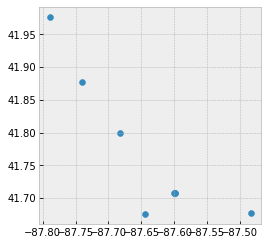

In [10]:
#zip the coordinates into a point object and convert to a GeoData Frame
geometry = [Point(xy) for xy in zip(df.X, df.Y)]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)
geo_df.plot()

Now let's tread these data as lines, we can take advantage of the column `ID` to `.groupby`. Luckily geopandas `.groupby` is consistent with the use in pandas. So here we `.groupby(['ID'])`, for each `ID` group we convert the values to a list, and store it in a Fiona `LineString` object.

<AxesSubplot:>

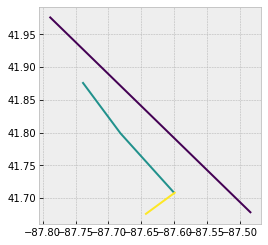

In [11]:
# treat each `ID` group of points as a line
lines = geo_df.groupby(['ID'])['geometry'].apply(lambda x:  LineString(x.tolist()))

# store as a GeodataFrame and add 'ID' as a column (currently stored as the 'index')
lines = gpd.GeoDataFrame(lines, geometry='geometry')
lines.reset_index(inplace=True)
lines.plot(column='ID')

### Creating Polygons
<!-- 
# Coordinates of the Helsinki Senate square in Decimal Degrees
coordinates = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]

# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)

# Let's see what we have
poly

 [[ -77.0412826538086, 38.99570671505043 ], [ -77.11681365966797, 38.936713143230044 ], [ -77.01896667480469, 38.807610542357594],
            [ -76.90910339355469,  38.892636142310295]]           
  -->



-------------------

[Adapted from Intro to Python GIS](https://automating-gis-processes.github.io/CSC18/lessons/L2/geopandas-basics.html#creating-geometries-into-a-geodataframe)


<!-- 
```{tip}  Becuase GeoPandas are so intertwined spend the time to learn more about here [Pandas User Guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html)
```
 
```{code-cell} ipython3
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns
```  
-->